In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os
import h5py

from skimage import graph, data, io, segmentation, color, filters
from skimage.measure import regionprops
from skimage.util.montage import montage2d
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries

# Overview

(175, 100)


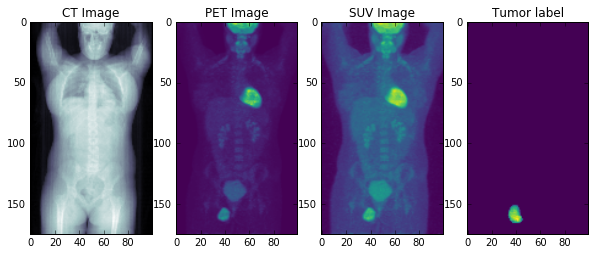

In [3]:
patient_index = 1
with h5py.File(os.path.join('..', 'input', 'lab_petct_vox_5.00mm.h5'), 'r') as p_data:
    id_list = list(p_data['ct_data'].keys())
    ct_image = p_data['ct_data'][id_list[patient_index]].value
    pet_image = p_data['pet_data'][id_list[patient_index]].value
    tumor_label = p_data['label_data'][id_list[patient_index]].value

ct_proj = np.mean(ct_image, 1)[::-1]
pet_proj = np.max(pet_image, 1)[::-1]
suv_max = np.sqrt(np.max(pet_image, 1)[::-1])
tumor_proj = np.mean(tumor_label, 1)[::-1]

print(ct_proj.shape)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (10, 5))
ax1.imshow(ct_proj, cmap='bone')
ax1.set_title('CT Image')
ax2.imshow(pet_proj, cmap='viridis')
ax2.set_title('PET Image')
ax3.imshow(suv_max, cmap='viridis')
ax3.set_title('SUV Image')
ax4.imshow(tumor_proj, cmap='viridis')
ax4.set_title('Tumor label')

# PET Histogram

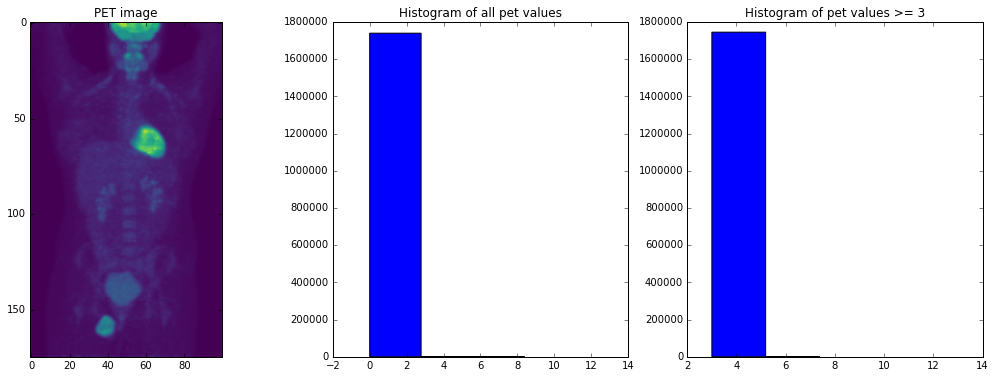

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
ax1.imshow(pet_proj, cmap='viridis')
ax1.set_title('PET image')

ax2.hist(pet_image.ravel(), bins=5)
ax2.set_title('Histogram of all pet values')

higher_pet = np.clip(pet_image, a_min=3, a_max=pet_image.max())
ax3.hist(higher_pet.ravel(), bins=5)
ax3.set_title('Histogram of pet values >= 3')

# Threshold PET 
Let's threshold the PET image with different threshold algorithms

In [36]:
threshold = filters.threshold_li(pet_proj)

thresholds = [filters.threshold_isodata, filters.threshold_li, filters.threshold_otsu, filters.threshold_yen]
values = [algo(pet_proj) for algo in thresholds]
print('threshold values:', values)

threshold values: [4.1597211080418441, 2.1932878504288276, 4.1597211080418441, 3.8878769825241237]


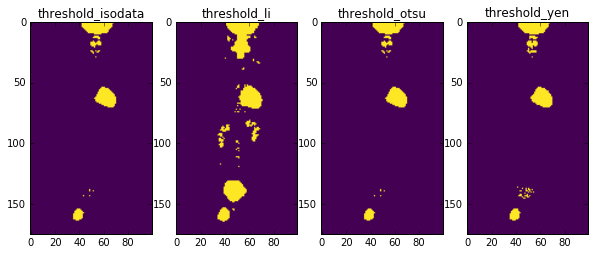

In [93]:
# plot the results
fig, ax = plt.subplots(1, len(thresholds), figsize=(10,5))
for t, a, n in zip(values, ax, thresholds):
    a.imshow(pet_proj > t, cmap='viridis')
    a.set_title(n.__name__)

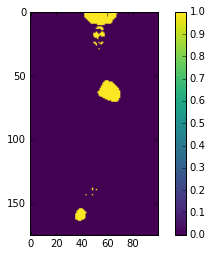

In [91]:
# Now let's use threshold_otsu
otsu_threshold = filters.threshold_otsu(pet_proj)
otsu_proj = pet_proj > otsu_threshold
fig, ax = plt.subplots()
im = ax.imshow(otsu_proj, cmap='viridis')
fig.colorbar(im)
plt.show()

# Segmentation with superpixel

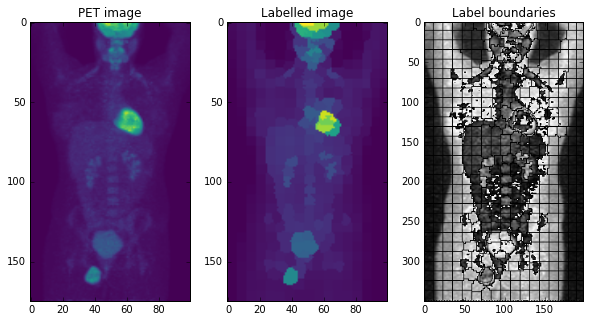

In [107]:
labels = slic(pet_proj, n_segments=500, compactness=1)
labels = labels + 1 # so that no labelled region is zero and ignored by regionprops

regions = regionprops(labels)
# assign color to each region
label_rgb = color.label2rgb(labels, pet_proj, kind='avg')
label_rgb_boundaries = segmentation.mark_boundaries(suv_max, labels, color=(0, 0, 0), mode='subpixel')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 5))
ax1.imshow(pet_proj, cmap='viridis')
ax1.set_title('PET image')

ax2.imshow(label_rgb, cmap='viridis')
ax2.set_title('Labelled image')

ax3.imshow(label_rgb_boundaries)
ax3.set_title('Label boundaries')

## Label selection

Now only select the superpixel regions where the threshold of the PET is true.

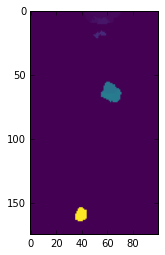

In [108]:
all_proj = np.stack((label_rgb, otsu_proj))
all_proj.shape

bright_segs = np.zeros_like(labels)

for i in np.unique(labels):
    if (pet_proj[labels == i]).mean() > otsu_threshold:
        bright_segs[labels == i] = labels[labels == i]

plt.imshow(bright_segs, cmap='viridis')

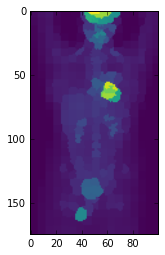

In [95]:
plt.imshow(label_rgb, cmap='viridis')